In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from urllib.request import urlopen
import requests
import re
import json
import nltk
import math
import wordcloud
from fa2 import ForceAtlas2
from community import community_louvain
import pandas as pd

from bokeh.models import ColumnDataSource, HoverTool
from bokeh.plotting import figure, show, from_networkx
from bokeh.io import output_notebook
from bokeh.layouts import layout, row, column
from bokeh.models import Circle, MultiLine
from bokeh.models.widgets import Tabs, Panel
from bokeh.transform import cumsum
from matplotlib.colors import to_hex

output_notebook()

Loading BokehJS ...

# DTU Course Network Analysis

This is the Explainer Notebook for the DTU Course Network Analysis project for course 02805 - Social Graphs and Interactions, by Jonathan Bendsen, Pauline Christiansen, and Christoffer Bjørner.

> **Note:** This Notebook uses Bokeh interactive plots. In order to see them you must trust the Notebook. (File -> Trust Notebook)

---

## Table of Contents

* [**Introduction**](#Introduction)
* [**Data Generation**](#Data-Generation)

---

## Introduction

An introduction to the project itself can be found in the associated report. In this Notebook, we perform all the analysis and data generation to accomplish the goal of the project. The process is divided into five steps:
1. Data Generation
2. TF-IDF Similarity Measuring
3. Network Construction
4. Community Detection
5. Visualizations & Results

Throughout the Notebook, the text will guide the idea and execution of each step, while the code comments will provide technical detail to the implementations themselves.

Let's get started.

---

# 1. Generating Data

The idea behind the project is to analyze the courses present in the *DTU Course Base*, with each their own fields and properties. The first step is to be able to *get* this information for any given course.

Below is the function we implemented that takes a course number, and scrapes the DTU Course Base website for that course for information. Luckily, the DTU Course Base uses a very easy-to-use site structure that made the process of grabbing the course properties consistent across all courses. The function uses Regex to find keywords and patterns in the raw HTML surrounding the desired properties, all of which were discovered via manual inspection of a handful of example pages' HTML.

The function returns a dictionary object with all the desired properties. It is implemented below:

In [2]:
# A function that returns a course object given a specific course number
def GetCourseInfo(course_num):
    
    # First, we need to get the page for the course
    link = f"http://kurser.dtu.dk/course/{course_num}"
    resp = requests.get(link, cookies={
        
        # This cookie must be set to a random token in order to mimic a browsing session, which DTU requires
        # It was randomly generated, but is static, meaning the whole scraping process acts as one complete session
        'ASP.NET_SessionId' : "twna5fybis2fwc4if4ydzgd3",
        
        # We also want to specifically retrieve the course information in English
        "{DTUCoursesPublicLanguage}": "en-GB"
    })
    
    # Only if we get an OK response on the request do we actually have information
    if resp.status_code == 200:
        course = {}
        text = resp.text
        
        # If this course is outdated, we retrieve the newest version we can find
        # This regex pattern occurs when a course redirects to a list of past year versions (if no current ones exist)
        # We simply find the newest one among that list, and retry on that year's hyperlink
        vols = re.search(r'<div><em>Volumes<\/em><\/div>[\r\n]*([\S\s]+?)<\/ul>', text)
        if vols:
            latest = re.findall(r'<a href="(.+?)".*?>\d+\/\d+<\/a>', vols.group(1))[-1]
            
            link = f"http://kurser.dtu.dk{latest}"
            resp = requests.get(link, cookies={
                'ASP.NET_SessionId' : "twna5fybis2fwc4if4ydzgd3",
                "{DTUCoursesPublicLanguage}": "en-GB"
            })
            
            # We won't attempt to try multiple layers
            if resp.status_code != 200:
                return
            
            text = resp.text
            
        # Now we can start processing the actual text. The first one is the General Course Objectives
        # Since this is the cornerstone to our analysis, if it cannot be found, we discard the course entirely
        # from our dataset
        general = re.search(r'<div class="bar">General course objectives<\/div>[\r\n]*([\S\s]+?)(?=<div)', text)
        if general is None:
            return
        
        # The ID is just the course number. The title and responsible teachers can be found rather simply
        # but we also specifically remove the course number from the title to clean it up
        course["ID"] = course_num
        course["Title"] = re.search(r'<h2 .+?>\s*([\S\s]+?)(?=<\/h2)', text).group(1)
        course["Title"] = course["Title"].replace(course_num, "").strip()
        course["Responsible"] = re.search(r'<label>Responsible(?:<.+?>)*[\r\n]*([\S\s]+?)(?=<\/a)', text).group(1)
        
        # A course can have more than 1 co-responsible. We will find the subsection of HTML that
        # corresponds to the coresponsible, then find all elements within that list to construct
        # The result is that CoResponsible is a list of co-responsible teachers
        corresponsible = re.search( r'<label>Course co-responsible<\/label>([\S\s]+?)(?=<label>)', text)
        if corresponsible:
            course["CoResponsible"] = re.findall(r'<a class="menulink" .+?>[\r\n]*([\S\s]+?)<\/a>', corresponsible.group(1))
            
            
        # Prerequisites is a bit more complicated. Some courses have a list of prerequisites, HOWEVER
        # in some instances, only one-of-a-set is required. This is usually indicated on the DTU Course Base
        # by Course1/Course2/Course3, whereas separately-required courses are separated by comma instead of slash
        # We choose to represent this by making the prerequisites a list-of-lists, where each sub-list is a series of
        # requirement sets (and in the case of individual requirement, this becomes a singleton list)
        #
        # We iterate over each found element, and if it ends in a '/', we build up a list, and when it doesn't
        # we submit that list to the course object's prerequisites
        prereq = re.search(r'<label>Mandatory Prerequisites<\/label>([\S\s]+?)(?=<label>)', text)
        if prereq:
            course["MandatoryPrerequisites"] = []
            cur_list = []
            for num, slash in re.findall(r'<a.*?class="CourseLink".*?>([\S\s]+?)<\/a>(\/)?', prereq.group(1)):
                cur_list.append(num)
                if slash == '':
                    course["MandatoryPrerequisites"].append(cur_list)
                    cur_list = []
        
        # Recommended Prerequisites follow the same structure, so we just repeat it
        prereq = re.search(r'<label>Recommended prerequisites<\/label>([\S\s]+?)(?=<label>)', text)
        if prereq:
            course["RecommendedPrerequisites"] = []
            cur_list = []
            for num, slash in re.findall(r'<a.*?class="CourseLink".*?>([\S\s]+?)<\/a>(\/)?', prereq.group(1)):
                cur_list.append(num)
                if slash == '':
                    course["RecommendedPrerequisites"].append(cur_list)
                    cur_list = []
        
        # ECTS blocking does NOT have those sub-sets, so for this one we can just collect all the courses
        # listed individually in a simple manner
        blocked = re.search(r'<label>Not applicable together with<\/label>([\S\s]+?)(?=<label>)', text)
        if blocked:
            course["Blocked"] = []
            for num in re.findall(r'<a.*?class="CourseLink".*?>([\S\s]+?)<\/a>', blocked.group(1)):
                course["Blocked"].append(num)
                    
        # Course types are listed in one long list near the type. This can belong to multiple types, so
        # we have a separate boolean for each. It is true if its corresponding type was present on the text.
        course["MSc"] = re.search("<div>MSc</div>", text) != None
        course["BSc"] = re.search("<div>BSc</div>", text) != None
        course["BEng"] = re.search("<div>BEng</div>", text) != None
        course["OfferedAsSingleCourse"] = re.search("<div>Offered as a single course</div>", text) != None
        
        # Additionally, each course can have several MORE types, such as if they are a technical course for a given
        # study line. While we could scrape this from the visible HTML, we actually found that these were all listed
        # in a much more Python-friendly way up in the embedded JavaScript (also in the HTML, but not visible)
        # We look for the code that specifies that, and then just read that list off like it was our own code
        coursetype_lines = re.search(r'var lines = \[([\S\s]+?)\]', text)
        course["CourseType"] = coursetype_lines.group(1).strip("[\r\n]*'[ \t\r\n]*").rstrip("[ ,']+").split("','")
        
        # The reamining fields are rather simple. The only thing to note is that some are converted to floats or ints
        # where appropriate
        course["ECTS"] = float(re.search("<label>Point\( ECTS \)<\/label><\/td><td>(.+?)<\/td>", text).group(1).replace(",", "."))
        course["Department"] = re.search(r'<label>Department<\/label><\/td><td.+?>[\r\n]*([\S\s]+?)(?=<\/td><\/tr>)', text).group(1)
        course["Location"] = re.search(r'<label>Location<\/label><\/td><td>([\S\s]+?)(?=<\/td><\/tr>)', text).group(1)
        course["Year"] = int(re.search(r'<h2 style=".+?text-align:right">[\r\n]*(\d+)\/\d+<\/h2>', text).group(1))
        
        # These are important to the TF-IDF analysis in this project. This is the descriptive texts
        # found on the right half of the course site structure. We will grab these at the end for readability purposes
        # when printing out courses for debugging
        course["General"] = general.group(1)
        course["Objectives"] = re.search(r'<div class="bar">Learning objectives<\/div>[\r\n]*([\S\s]+?)(?=<div)', text).group(1)
        course["Content"] = re.search(r'<div class="bar">Content<\/div>[\r\n]*([\S\s]+?)(?=<div)', text).group(1)
        
        # And finally, we have our result: One neatly packed object representing most of the information for this course
        return course

So now we have a method of getting a course from a given course number. Next, in order to reduce our limitations, we want to *crawl* these courses, rather than just relying on a list of course numbers we might be able to find on our own. What this means, is that after processing of a single course, the crawler is *recursively called* on all other courses referenced in the current one - through the prerequisites.

The `CrawlCourse` function below serves as the starting point to our data gathering. Of course, the crawler should do nothing if it attempts to reach a course which it had already previously done. However, whenever possible, it should spread out to as many courses as it can discover. This is the implementation:

In [3]:
# Recursive function: Gather the information of a course and append it to the courses dictionary,
# then recursively repeating on all prerequisite courses found in the process
def CrawlCourse(course_num):
    
    # If we already handled this course in a previous recursion, do nothing
    if course_num in courses:
        return
    
    # Get the course for the current number
    # We do nothing if we cannot get information on it
    course = GetCourseInfo(course_num)
    if course is None:
        return
    
    # Store the course
    courses[course_num] = course
    
    # Additionally, we also want to build up a list of teachers
    # This gives us insight into what teachers are responsible for what courses, as well as
    # how many teachers we have in total
    responsible = course["Responsible"]
    if not responsible in teachers:
        teachers[responsible] = {"Responsible": [], "CoResponsible": []}
    teachers[responsible]["Responsible"].append(course)
    
    # Same with co-responsible
    if "CoResponsible" in course:
        for coresponsible in course["CoResponsible"]:
            if not coresponsible in teachers:
                teachers[coresponsible] = {"Responsible": [], "CoResponsible": []}
            teachers[coresponsible]["CoResponsible"].append(course)

    
    # Now we want to recursively crawl each and every other course found in both kinds of prerequisites
    for key in ["MandatoryPrerequisites", "RecommendedPrerequisites"]:
        if key in course:
            for l1 in course[key]:
                for l2 in l1:
                    CrawlCourse(l2)

You may have noticed that the `CrawlCourse` function also constructs a list of teachers. This is no longer actually used in this project, but remains here for proof that it can be done, and to provide a little extra fun trivia.

**Now it's time** to actually gather all the data! First, we need some way to *find* all the course numbers available to us. Luckily, the DTU Course Base also contains a *search* function, and it just so happens to be that you can actually search without filters and find ALL courses listed! We will use that as an entry point, then run our crawler on each one found:

> Note: This code block is disabled with an `if False`, as this function took a rather long time, and the results of this has instead been pre-computed so it only had to be done once.

In [4]:
if False:
    
    # Prepare our list of courses and teachers
    courses = {}
    teachers = {}
    
    # Find the full list of courses through a search with no filters!
    all_courses_resp = requests.get("https://kurser.dtu.dk/search?CourseCode=&SearchKeyword=&Department=1&Department=10&Department=12&Department=13&Department=22&Department=23&Department=24&Department=25&Department=26&Department=27&Department=28&Department=29&Department=30&Department=33&Department=34&Department=36&Department=38&Department=41&Department=42&Department=46&Department=47&Department=59&Department=IHK&Department=83&CourseType=&TeachingLanguage=", cookies={
        'ASP.NET_SessionId' : "twna5fybis2fwc4if4ydzgd3",
        "{DTUCoursesPublicLanguage}": "en-GB"
    })

    # If we could get a result ...
    if all_courses_resp.status_code == 200:
        
        # ... find all the "course" links present in the HTML ...
        all_courses = re.findall(r'<a href="\/course\/(.*?\b(?<!gotoStudyplanner))">', all_courses_resp.text)

        # ... and then crawl them!
        for course_num in all_courses:
            CrawlCourse(course_num)

---

### Load the pre-computed data instead

In [5]:
# This code reads the resulting course dictionary from above from the Github repository
# The teachers set can be inferred from the course data
if True:
    with urlopen("https://raw.githubusercontent.com/s164428/SocialNetworksMarvelDCData/main/courses.json") as f:
        courses = json.load(f)
        teachers = {}

        for num, course in courses.items():
            responsible = course["Responsible"]
            if not responsible in teachers:
                teachers[responsible] = {"Responsible": [], "CoResponsible": []}
            teachers[responsible]["Responsible"].append(num)

            if "CoResponsible" in course:
                for coresponsible in course["CoResponsible"]:
                    if not coresponsible in teachers:
                        teachers[coresponsible] = {"Responsible": [], "CoResponsible": []}
                    teachers[coresponsible]["CoResponsible"].append(num)

---

And now we can see the results of our dataset!

In [6]:
print(f"{len(courses)} Courses have been found, along with {len(teachers)} Teachers across these.")

1956 Courses have been found, along with 1144 Teachers across these.


That is a very large amount of courses, and quite a few teachers! Alright, with our data ready, we can move on to the next part!

---

# 2. Measuring the TF-IDF Similarity

We can perform *TF-IDF* on the *descriptive fields* of each course to be able to measure the similarities between any pair of courses. This will form the basis of our network, which will be constructed from these pairwise similarities. So the first step is to be able to measure that!

We will use Python's `nltk` package to tokenize and lemmatize the text of each course, after it has been cleaned from special characters and symbols using Regex.

In [7]:
nltk.download("omw-1.4")
nltk.download("wordnet")

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\jona0\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jona0\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

From there, we need to find the *word count* for each separate word present in that course's text. This needs to be stored for every course. However, with that many courses, the overhead and performance impact of storing a full dictionary multiple times is not efficient.

We found that **Sparse Matrices** would best serve the purpose of this storage. By mapping each word discovered to an integer, we can numerically assign to a *column* in a large matrix. Each row would then represent each course, and the number in the cells are the word count for that column's word, in that row's course's description.

Using the Sparse Matrix data structure, specifically the *Compressed Sparse Row* implementation, we can efficiently store the total word count across all courses despite the large global vocabulary. As a bonus, this also aligns each value column-wise to other rows, which will be immensely useful later in the Cosine Similarity calculations.

In [8]:
from scipy.sparse import csr_matrix

# Construct a big Sparse Matrix consisting of all the courses' word counts, where each
# row is a course, and each column is a unique word mapped by a global vocabulary!

# First we need to initialize the vocabulary. The "vocabulary" dictionary maps each word to an integer value (the column index)
# while the list below does the reverse; mapping the integer value (index) back to the word
vocabulary = {}
vocabulary_reverse = []

# These three lists make up the structure of the Compressed Sparse Row data structure. They are a bit advanced, so try to keep up:
# The overall data structure can be thought of as (column, data) pairs pointing only to the cells with non-zero values
# and specifying what value exists in that cell instead. Here are the three components:
#     - The "word_id" list contains the sequence of column numbers we are appending data to in the matrix
#     - The "count" list contains the sequence of data added to the matrix, in parallel with the list above
#     - The "indptr" lists the "boundaries" of each row in the matrix, relative to the lists above. If indptr = [0, 100, 300]
#       then that means the first row can be found in "word_id[0:100]" and "count[0:100]", and the second row [100:300]
# The structure of this sparse matrix will be built up over time, by continuously appending (word_id, 1)-pairs to the
# two main lists, before finally rounding off the course's row when finished with it fully by appending the upper boundary
# to the indptr list. Finally, we will sum duplicates, meaning all those (word_id, 1)-pairs merge into (word_id, X) for each
# row, where X is the total amount of times that word appeared in that course.
indptr = [0]
word_id = []
count = []

# Along the way, we will also count how many courses each word appears in at least once.
# This will be used later during the TF-IDF computations
# This list is also indexed by the word_id.
term_course_counts = []

# Finally, we also need to remember the order of courses. As we will reduce our list of courses to simple rows of a matrix,
# we must have some way to figure out what row a course belongs to in this matrix. This is done by mapping each course number
# to the row index it was processed in.
# Additionally, we also have a reverse mapping list below, just like our vocabulary
course_indices = {}
course_names = []


############# Finally! We can get started!!
wnl = nltk.WordNetLemmatizer()

# Let's iterate over all courses!
for num, course in courses.items():
    
    # We will discard all courses that are not from the current year
    if course["Year"] != 2022:
        continue

    # Then we will join the three description fields together into one long string, and then clean it
    text = "\n".join([course["General"], course["Objectives"], course["Content"]])
    text = re.sub("<[^<>]*?>", " ", text)
    text = re.sub("[^A-Za-z0-9\s]+", " ", text).lower()
    
    # Then we will tokenize it using nltk to get the list of words
    tokens = nltk.wordpunct_tokenize(text)

    # In order to only count each word exactly once in the "term_course_counts" list,
    # we will keep track of the ones we already counted in this set
    visited_words = set()
    
    # Now we start to go through all words
    for t in tokens:
        
        # We will lemmatize it to remove stems and reduce our vocabulary dimensionality
        word = wnl.lemmatize(t)
        
        # If this is the first time we've encountered this word, it must be mapped to a new integer
        if word not in vocabulary:
            # This word shall now be numbered by the order of discovery
            vocabulary[word] = len(vocabulary)
            vocabulary_reverse.append(word)
            
            # Additionally, this also means the term_course_count list must expand by 1 member
            term_course_counts.append(0)
            
        # We map the word to its corresponding number
        w_id = vocabulary[word]
        
        # If this is the first time we've seen this word in this course, we add +1 to the course count for this word
        if w_id not in visited_words:
            term_course_counts[w_id] += 1
            visited_words.add(w_id)
        
        # Finally, we append the (word_id, 1) pair to the data
        word_id.append(w_id)
        count.append(1)

    # When we're done with this course, we round off the row in the sparse matrix by designating its ending point here
    indptr.append(len(count))
    
    # We will then remember the order this was processed as well
    course_indices[num] = len(course_indices)
    course_names.append(num)
    
    
    
    
# With our three CSR lists, we can construct our Word Count sparse matrix! :D
wordcount = csr_matrix((count, word_id, indptr))
wordcount.sum_duplicates()

# (We also just quickly numpy this array so we can index it more advanced later)
term_course_counts = np.array(term_course_counts)

The sparse matrix structure really helps us save space and boost efficiency, while retaining the high-dimensionality of the global vocabulary. We can take a closer look at the statistics of the work we've just performed:

In [9]:
print(f"There are a total of {wordcount.shape[0]} courses processed, with a total of {len(vocabulary)} words indexed.")
print(f"The Sparse Matrix contains {wordcount.getnnz()} non-zero elements, cutting down storage by {(1-(wordcount.getnnz()/(wordcount.shape[0]*wordcount.shape[1])))*100:.3f}%. (From [{wordcount.shape[0]} x {wordcount.shape[1]}] = {wordcount.shape[0]*wordcount.shape[1]})")

There are a total of 1694 courses processed, with a total of 12775 words indexed.
The Sparse Matrix contains 222658 non-zero elements, cutting down storage by 98.971%. (From [1694 x 12775] = 21640850)


**Wow!** 99% reduction in space, now that is efficient!

Let's move on.

We have our word counts across all courses now. The next thing to do, is to compute the *TF-IDF* scores of each of these words in each course. Another handy bonus of the Sparse Matrix structure, is that we only process the data that is actually relevant when iterating.

We will make a function that, when given a word count sparse matrix and a list of how many "documents" each word exists in, will return a sparse matrix of the same skeleton as the word count one, but with the *TF-IDF* scores in the data field instead. Additionally, this supports normalizing the vectors, which will allow us to shortcut the *Cosine Similarity* later!

In [10]:
from scipy.sparse.linalg import norm

# Compute TF-IDF Matrix from a given word count matrix, and a list of how many documents each word exists in!
def ComputeTFIDFMatrix(matrix, term_document_counts, normalize=True):
    
    # We prepare construction of our new matrix. Since the rows and columns are all the same,
    # we can just copy these into our new matrix too!
    indptr = matrix.indptr
    indices = matrix.indices
    
    # Additionally, we already know the size of the data, meaning we can instantialize it all at once already!
    data = np.zeros(len(matrix.data), dtype=float)
    
    # Now we will iterate each row. This range is looping from 0 to the number of rows in the matrix (given by its shape)
    for i in range(matrix.shape[0]):
        
        # Remember how indptr worked?
        # We will exploit that to know exactly what part of the matrix's index and data lists we need to go through!
        index_start = matrix.indptr[i]
        index_end = matrix.indptr[i+1]

        # Get the total word count of the article by summing this sub-section of the data (counts) array
        sum_word_count = matrix.data[index_start:index_end].sum()

        # Now we iterate over each (word, count)-pair in this row
        # This is done by simply iterating from the start index to the end index we found earlier! :D
        for j in range(index_start, index_end):
            
            # Compute the term frequence as the count for this word, divided by the total word count of this whole row
            tf = matrix.data[j]/sum_word_count
            
            # Compute the inverse-document frequency, by taking the log of the inverse fraction of documents this word existed in
            idf = math.log(matrix.shape[0]/term_document_counts[matrix.indices[j]])
            
            # Finally, the TF-IDF score is just them multiplied together!
            # We just set this data value, directly into our new data array, exactly at the same position!
            data[j] = tf*idf
            
    # We can construct our resulting matrix by just using these copied lists
    result = csr_matrix((data, indices, indptr))

    # Bonus feature: Normalize!
    if normalize:
        
        # Get the norms across each row using Scipy's own Sparse Matrix Norm implementation (specifically made for these)
        norms = norm(result, axis=1)
        for i in range(result.shape[0]):
            
            # Sometimes the norm is zero. This happens if all words had a TF-IDF score of 0, or if all words were filtered
            # out during the cleaning. In this case, we don't want to divide
            if norms[i] != 0:
                result.data[result.indptr[i]:result.indptr[i+1]] /= norms[i]
                
        # When normalize is set to true, we will also return the norms list. This isn't really strictly useful
        # but it does help us shortcut TF-IDF later by saving some work if we know it's already gonna be zero
        return result, norms
    
    # Otherwise just the result is fine
    return result

Now we can compute the TF-IDF on our word count matrix, to get the TF-IDF of all courses in one go!

In [11]:
tfidf, norms = ComputeTFIDFMatrix(wordcount, term_course_counts, normalize=True)

Fantastic. We're almost done!

Next, we want to be able to measure the *similarity* between two different rows in a TF-IDF Sparse Matrix like this. The similarity between two TF-IDF instances can be thought of as the *cosine similarity* between the *vectors* representing the TF-IDF score. The important thing here, is that the vectors must be *parallel* -- that is, each column in each vector must correspond to the same measure in the other vector for the similarity to make sense.

_**Remember how our Sparse Matrix mapped only the same words to the same columns?**_

The Cosine Similarity is defined as the *dot product* between these two vectors, divided by the *product of their lengths*. Now, remember that we also chose to normalize our TF-IDF rows? This means that the length is really 1, reducing the Cosine Similarity to simply a dot product.

But how do we compute the dot product when we are working with this weird *Sparse Matrix* thing?

The dot product is simply the sum of products across each parallel cell in both vectors. Since we know the product of anything and _**0**_ is always 0, we know that they cannot add to the sum. And since our *Sparse Matrix* only stores *non-zero* elements in each row, we can simply limit ourselves to _only look at the columns that **both** rows have in common!_

This provides a MASSIVE efficiency improvement over generating the full-length 12,775-dimensional vector and dotting those! The code below demonstrates how to do that:

In [12]:
# Compute the TF-IDF Similarity of a matrix and norms, given two different row indexes
def TF_IDF_Similarity(matrix, norms, course1, course2):
    
    # Shortcut: If any of the rows had a norm of zero, we can save ourselves the work
    if norms[course1] == 0 or norms[course2] == 0:
        return 0
    
    # Get the columns/words of each of these two rows
    words1 = matrix.indices[matrix.indptr[course1]:matrix.indptr[course1+1]]
    words2 = matrix.indices[matrix.indptr[course2]:matrix.indptr[course2+1]]
    
    # Find the INTERSECTION - that is, only those they have in common - for both of these word lists
    # With "return_indices=True" we get the position where these words are relative to each their own word list
    _,indices1,indices2 = np.intersect1d(words1, words2, assume_unique=True, return_indices=True)
    
    # Now we can just return the dot product of the *data* in the matrix, starting from the start-point of that row,
    # and offset by the indices of the words in common, in that row's list
    # This holds because the "data" and "indices" lists are parallel; The indices correspond
    return np.dot(matrix.data[matrix.indptr[course1] + indices1], matrix.data[matrix.indptr[course2] + indices2])

# We can test it a little bit here!
print(f"\"{courses['01005']['Title']}\" and \"{courses['01901']['Title']}\" have a similarity of {TF_IDF_Similarity(tfidf, norms, course_indices['01005'], course_indices['01901'])}")
print(f"\"{courses['01005']['Title']}\" and \"{courses['26000']['Title']}\" have a similarity of {TF_IDF_Similarity(tfidf, norms, course_indices['01005'], course_indices['26000'])}")

"Advanced Engineering Mathematics 1" and "Calculus and algebra 1" have a similarity of 0.3599952218752467
"Advanced Engineering Mathematics 1" and "General Chemistry" have a similarity of 0.0274596368588801


Alright! Now we have the ability to measure the Cosine Similarity between any two given TF-IDF rows in a Sparse Matrix! The final step in our similarity analysis is to do this for *all* courses, and generate the **Complete Similarity Matrix**, which is like a *distance matrix*, but for similarity instead.

This computation is done below:

In [13]:
# Compute the full NxN matrix, where N is the number of courses
# Fill it with nan's to begin with. The filling chosen here will determine what the (uncomputed) diagonal will contain
sim = np.full((tfidf.shape[0], tfidf.shape[0]), np.nan)

# Now we just iterate over all courses
for i in range(tfidf.shape[0]):
    
    # Iterate over all courses AHEAD of the upper iteration one
    # This prevents us from doing any duplicate comparisons the other way around! :D
    for j in range(i+1, tfidf.shape[0]):
        
        # Compute the TF-IDF Similarity between these two
        sim[i,j] = TF_IDF_Similarity(tfidf, norms, i, j)
        sim[j,i] = sim[i,j]

# Because of float rounding errors, we had issues with some scores being 1.0000003, causing errors in code later on
# To solve this, we simply clip our array between 0 and 1
sim = np.clip(sim, 0, 1)

And that's it! We've now successfully measured the similarity between **ALL** pairs of courses! This provides the foundation for our network analysis. Let's proceed!

---

# 3. Building the Similarity Network

The idea of this network is to construct a *complete* graph, where every node is a course, and all of them have edges to all other nodes. These edges then have *weights* which correspond to the *similarity* between those two courses. Higher edge weights, means the courses are more similar.

To construct this, we simply initialize an empty Graph, and then use `add_weighted_edges_from` where we loop over all *non-nan* values in our complete similarity array above, and connect the corresponding courses with this weight!

In [14]:
# Initialize our Graph
G_similarity = nx.Graph()

# Add an edge for all non-nan similarity values in our fully computed matrix
# The node names are given from the course name by this row number (created earlier)
# Since the graph is not a MultiGraph, we will only end up with 1 edge between each, even though the matrix contains 2 entries
# per pair (one in either direction)
G_similarity.add_weighted_edges_from([(course_names[idx1], course_names[idx2], sim[idx1, idx2])
                                      for idx1, idx2 in np.argwhere(~np.isnan(sim))
                                     ])

# Let's take a look at our network!
print(G_similarity)

Graph with 1694 nodes and 1433971 edges


---

## Statistics

Let's take a closer look at some of the statistics of our network. It doesn't make sense to look at the *degree distribution*, as all nodes will have a *full degree*, however we can modify the concept a little bit, and look at the *edge weight* distribution, as well as the *weighted* degree distribution. The latter of the two is simply the *sum of edge weights* each node has, which is similar to the idea of a degree distribution. The *edge weight* distribution looks more at the edges themselves, and counts how many edges exists with each weight, in the shape of a histogram.

> For succintness, only the *edge weight distribution* has been included in the report.

We plot all these together in the plot below:

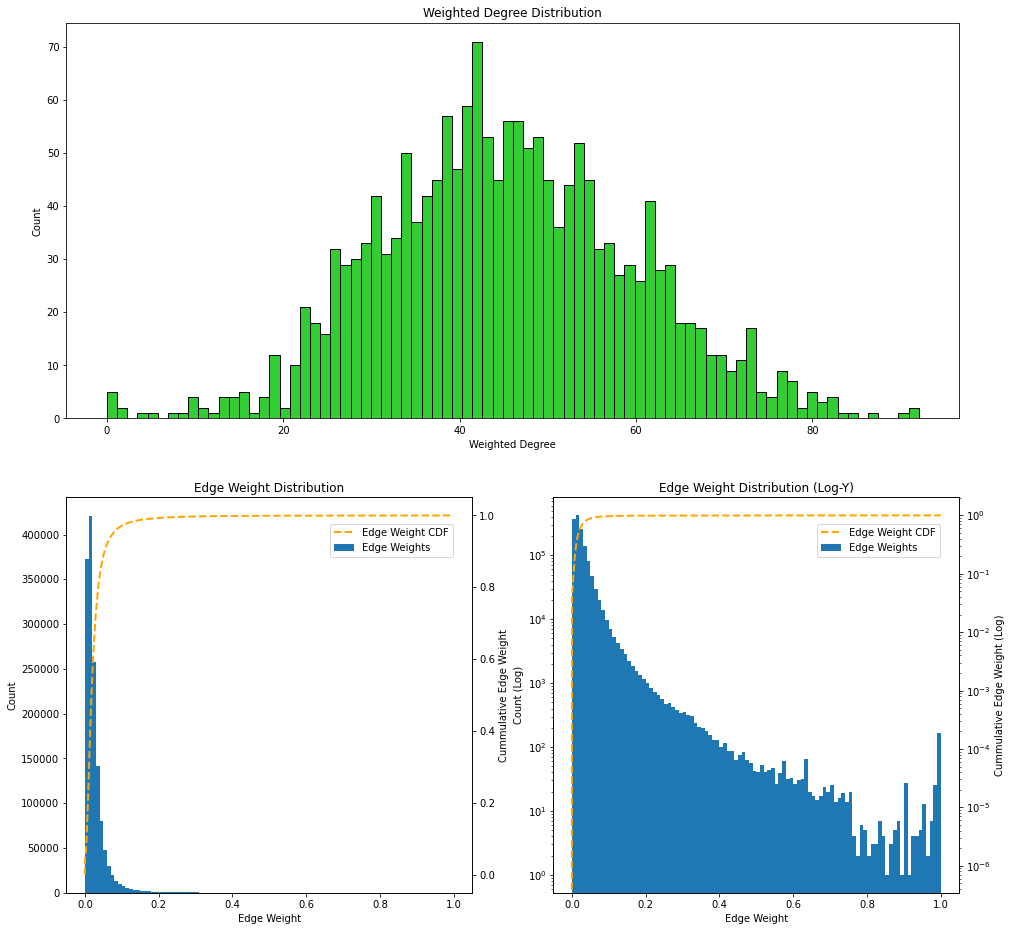

In [15]:
# Get our complete list of edge weights
edge_weights = np.sort(np.array([weight for _,_,weight in G_similarity.edges(data="weight")]))

# Get our weighted degree distribution. NetworkX supports doing this directly, so that's nice!
degree_distribution = np.array([d for n,d in G_similarity.degree(weight="weight")])

# Now it's time to plot!
# We use a nice mosaic layout to create a more easily readable multi-plot
fig, axs = plt.subplot_mosaic([["Deg", "Deg"], ["Hist", "LogHist"]], figsize=(16,16))

# The weighted degree distribution is just a simple histogram over the weighted degrees of all nodes
axs["Deg"].hist(degree_distribution, bins=80, color="limegreen", edgecolor="black")
axs["Deg"].set_title("Weighted Degree Distribution")
axs["Deg"].set_xlabel("Weighted Degree")
axs["Deg"].set_ylabel("Count")


# We want to plot the edge weight distribution both in normal, and in logarithmic scale
# as this will most closely mimic the notion of a degree distribution for our use case
# We will plot the histogram of edge weights, but on top of it plot the CDF of this distribution
# to get a nicer view on how big a portion remains after a given threshold
axs["Hist"].hist(edge_weights, bins=100, label="Edge Weights")
axs["Hist"].plot([0], [0], color="orange", linewidth=2, linestyle="--", label="Edge Weight CDF")
ax2 = axs["Hist"].twinx()
ax2.plot(edge_weights, np.linspace(0,1,len(edge_weights)), color="orange", linewidth=2, linestyle="--")

axs["Hist"].set_title("Edge Weight Distribution")
axs["Hist"].set_xlabel("Edge Weight")
axs["Hist"].set_ylabel("Count")
ax2.set_ylabel("Cummulative Edge Weight")
axs["Hist"].legend(loc=(0.65, 0.85))

# Repeat the same as above, but with a logarithmic Y-axis
axs["LogHist"].set_yscale("log")
axs["LogHist"].hist(edge_weights, bins=100, label="Edge Weights")
axs["LogHist"].plot([0], [0], color="orange", linewidth=2, linestyle="--", label="Edge Weight CDF")
ax2 = axs["LogHist"].twinx()
ax2.set_yscale("log")
ax2.plot(edge_weights, np.linspace(0,1,len(edge_weights)), color="orange", linewidth=2, linestyle="--")

axs["LogHist"].set_title("Edge Weight Distribution (Log-Y)")
axs["LogHist"].set_xlabel("Edge Weight")
axs["LogHist"].set_ylabel("Count (Log)")
ax2.set_ylabel("Cummulative Edge Weight (Log)")
axs["LogHist"].legend(loc=(0.65, 0.85))

plt.show()

We can see that the degree distribution seems to follow a *normal distribution*, while the *edge weight distribution* shows more of a power law, like you'd expect from a real network. This does make sense, as it is really the edges that form the backbone of this whole network, since it is a complete graph.

We can also look closer at different percentiles of the edge weight distribution:

In [16]:
print(f"Percentiles 90%, 95%, 99%: {np.percentile(edge_weights, 90)}, {np.percentile(edge_weights, 95)}, {np.percentile(edge_weights, 99)}")

Percentiles 90%, 95%, 99%: 0.05323764971467172, 0.07572273133279897, 0.16792847595361424


We see that even for *99%* of edges, the similarities are still only just about 15%. The vast majority of courses are not very similar.

---

## Reducing the Network

We want to reduce the network to lower the computational requirement, while keeping most of the meaningful data intact. To do this, we will _threshold_ the edges by some specific value, and then remove all edges from the network that does not pass that value.

We have chosen _**10%**_ as our threshold, as it is even still a very low similarity to even consider, but cuts off well over 95% of our edges and thus our computational work. Additionally, we will then take the _greatest giant component_ of the resulting network, cutting those nodes off that have entirely less than 10% similarity to _any_ other course.

In [17]:
# 10% similarity
threshold = 0.1

# Let's make our new thresholded network a copy, so that we won't destroy the old one
G_similarity_thresholded = G_similarity.copy()

# Remove all edges where the weight is less than the threshold
G_similarity_thresholded.remove_edges_from([(n1, n2) for n1, n2, w in G_similarity_thresholded.edges(data="weight") if w < threshold])

# Compute the biggest giant component and replace our network with that
G_similarity_thresholded = G_similarity_thresholded.subgraph(sorted(nx.connected_components(G_similarity_thresholded), key=len, reverse=True)[0])

# Let's take a look at our stats!
print("Original network:", G_similarity)
print("Reduced network:", G_similarity_thresholded)
print(f"The reduction removed {G_similarity.number_of_edges() - G_similarity_thresholded.number_of_edges()} ({(G_similarity.number_of_edges() - G_similarity_thresholded.number_of_edges())/G_similarity.number_of_edges()*100:.2f}%) of edges, and {G_similarity.number_of_nodes() - G_similarity_thresholded.number_of_nodes()} nodes")

Original network: Graph with 1694 nodes and 1433971 edges
Reduced network: Graph with 1686 nodes and 40903 edges
The reduction removed 1393068 (97.15%) of edges, and 8 nodes


Hmm, very interesting with those 8 nodes removed, huh?

This means these 8 nodes had less than _10%_ similarity to ALL other courses! That means either these courses have no TF-IDF scores, or else, these are the most unique courses in all of DTU's Course Base. Let's try and take a closer look at each of them, as well as which course they were the most similar to:

In [18]:
print(f"Courses with less than {threshold*100}% similarity to all other courses in DTU Course Base:\n")
for num in [n for n in G_similarity.nodes if n not in G_similarity_thresholded.nodes]:
    course = courses[num]
    title = course["Title"].replace("\r\n", " ")
    print(f"--- {num} - {title}")
    
    similarities = sim[course_indices[num], :].copy()
    similarities[course_indices[num]] = 0
    
    most_similar_index = np.argmax(similarities)
    most_similar = courses[course_names[most_similar_index]]
    print(f"Most similar to: {most_similar['ID']} - {most_similar['Title']} ({similarities[most_similar_index]*100:.2f}%)\n")

Courses with less than 10.0% similarity to all other courses in DTU Course Base:

--- 10590 - Illustration of scientific content
Most similar to: 41392 - Journal club in fluid mechanics (7.89%)

--- 25201 - Introduction to safety at sea and fieldwork in Greenland
Most similar to: 01003 - Advanced Engineering Mathematics 1 (0.00%)

--- 25202 - Fisheries Engineer I: Describe exploitation and management of fish
Most similar to: 01003 - Advanced Engineering Mathematics 1 (0.00%)

--- 25203 - Fisheries Engineer II: Comparison of exploitation and management of different fish and shellfish species
Most similar to: 01003 - Advanced Engineering Mathematics 1 (0.00%)

--- 25205 - Basic modelling and statistics in R
Most similar to: 01003 - Advanced Engineering Mathematics 1 (0.00%)

--- 25206 - Preparatory chemistry and physics
Most similar to: 01003 - Advanced Engineering Mathematics 1 (0.00%)

--- 30574 - Earth observations for monitoring changes (EO4Change)
Most similar to: 30552 - Satellite 

---

Some of these have the highest similarity still be 0%. This means these courses have no TF-IDF scores, either through having only words that all other courses also have, or having no text after the cleanup filtering.

However, the remaining courses show us the _most unique courses_ based on their descriptions, and they are:
* **10590:** Illustration of scientific content
* **41968:** Bridge Structures
* **30574:** Earth observations for monitoring changes

The most unique courses in the whole of DTU's Course Base. Very interesting!

Anyway, with the network now constructed, it's time to get to the real meat of the analysis: *Community Detection!*

---

# 4. Community Detection

To perform community detection, we used *Python-Louvain*'s implementation. It supports generating communities via *weights*, which is exactly what we need!

Now, due to how community detection is always random to some degree, to ensure consistent results, we have also pre-computed these communities and uploaded them to the Github repository. The code below both demonstrates how they were found and saved, but due to the `if False-else` statement, the code only loads the results we computed. Let's get them down!

In [19]:
if False:
    # Simply use python-louvain's implementation with the "weight" parameter on our network
    partition = community_louvain.best_partition(G_similarity_thresholded, weight="weight")
    with open("communities.json", "w") as f:
        json.dump(partition, f)
        
else:
    with urlopen("https://raw.githubusercontent.com/s164428/SocialNetworksMarvelDCData/main/communities.json") as f:
        partition = json.load(f)
        
# Let's see how many communities we got!
total_communities = len(set(partition.values()))
print(f"Total amount of Communities: {total_communities}")

Total amount of Communities: 11


11 communities were detected. To take a closer look at what these communities are, let's do TF-IDF on the whole communities too! This will be the TF-IDF scores of the _total_ word count among all courses present in each community!

In [20]:
# First, let's make a list that contains the list of all course numbers for each community
# This will make iteration easier later on
community_courses = [[] for _ in range(total_communities)]
for course, c in partition.items():
    community_courses[c].append(course)

# Now we will make our TF-IDF scores for the communities. We will re-use the same Sparse Matrix format as earlier
# due to its efficiency, but also because we already made functions that can do it all for us! Why waste that? :D
indptr = [0]
words = []
counts = []
term_community_count = np.zeros(len(vocabulary), dtype=int)

# Go through each community. This will be our row
for community in community_courses:
    
    # In this case, the visited_words is *per community*, as each community represents only one whole "document"
    visited_words = set()
    
    # Now we go through each course in the community
    for course in community:
        
        # Get the word count of this course by getting its row in the original sparse matrix we already counted
        wordcount_row = wordcount.getrow(course_indices[course])
        
        # Iterate over this row's (word_id, count)-pairs, and simply add them to our own!
        for w_id,count in zip(wordcount_row.indices, wordcount_row.data):
            words.append(w_id)
            counts.append(count)
            
            # (Do our little term document count process too)
            if w_id not in visited_words:
                term_community_count[w_id] += 1
                visited_words.add(w_id)
    
    # And round off the row at the end of the whole *community*
    indptr.append(len(counts))

# Now we can simply construct our sparse matrix, and then ALSO TF-IDF it using our function earlier
# to get our complete TF-IDF scores for all our communities in one go!
community_tfidf, community_norms = ComputeTFIDFMatrix(csr_matrix((counts, words, indptr)), term_community_count, normalize=True)

It's always nice when you can reuse code you've made earlier for multiple purposes.

Now we have our TF-IDF scores for each community! This will let us get a bit of an insight into what these communities represent. To get a brief overview, we can quickly try to see the *top 5* words in each community with the simple code here:

In [21]:
print("Top 5 words for each community:")
for c in range(community_tfidf.shape[0]):
    c_row = community_tfidf.getrow(c)
    
    # Collect our term scores as (score, word)-pairs, which we can then sort in descending order!
    term_scores = sorted([(score, word) for word, score in zip(c_row.indices, c_row.data)], reverse=True)
    
    # Print out the top 5!
    print(f"Community {c+1}: {[vocabulary_reverse[word] for score, word in term_scores[:5]]}")

Top 5 words for each community:
Community 1: ['differential', 'fourier', 'momentum', 'algebraic', 'finite']
Community 2: ['fire', 'ventilation', 'bim', 'indoor', 'heat']
Community 3: ['marketing', 'entrepreneurial', 'business', 'lean', 'machining']
Community 4: ['fishery', 'fishing', 'water', 'urban', 'pavement']
Community 5: ['turbine', 'converter', 'wind', 'electrochemical', 'voltage']
Community 6: ['ku', '2023', 'kurser', '2022', 'see']
Community 7: ['coordinator', 'managerial', 'leadership', 'organizational', 'negotiation']
Community 8: ['protein', 'compound', 'fermentation', 'molecular', 'microbial']
Community 9: ['supervisor', 'phd', 'scientific', 'adjust', 'eventure']
Community 10: ['image', 'ray', 'beam', 'quantum', 'ceramic']
Community 11: ['security', 'embedded', 'robot', 'cryptographic', 'authentication']


What an interesting look into our communities. It seems like community 1 contains a lot about mathematics, while community 2 seems to focus a lot on fire and indoor safety (likely construction?). We see an entrepreneur, and a fishing community, a community for electro-mechanics, and one seemingly for ... other courses in University of Copenhagen (KU)?

---

# 5. Visualization and Results

We've done our data gathering, we've done our similarity measuring, and we've done our network construction and analysis. Now it's time to look at the results.

These top-5 words for each community really gives a good insight into the communities already, but we want to see a bit more about them. We will now approach our first **interactive plot**. This plot will be a 2-in-1 plot: Half of it will show the *department distribution* among all courses within a community. This gives us a very interesting insight into *how diverse* each community may be. The other half is a *WordCloud* over the TF-IDF scores of that community. This would give us a deeper insight into the community than just the top-5 words we save above, plus it looks cooler.

All of this will be collected on *tabs*, allowing you, the reader, to interactively inspect each community individually!

In [22]:
# First, we generate the WordClouds! As Bokeh (our interactive plot manager) does not support WordCloud natively,
# we export the images generated by the WordCloud as png files, then simply throw it into Bokeh as an image

# To save you the hassle, this is also pre-computed and uploaded to the Github. Aren't we nice? :)
if False:
    
    # In case you DO wanna see how it's done, we do it by looping over all community rows in our TF-IDF Sparse Matrix
    for c in range(community_tfidf.shape[0]):
        
        # Get the row
        c_row = community_tfidf.getrow(c)
        
        # Then construct the dictionary of {word: score} for each (word_id, score)-pair in the matrix row
        term_scores = {vocabulary_reverse[word]: score for word, score in zip(c_row.indices, c_row.data)}
        
        # We make a wordcloud in our specific dimensions, fit the words, and just write it to a file
        wc = wordcloud.WordCloud(background_color='white', width=550, height=400)
        wc.fit_words(term_scores)
        wc.to_file(f"Community_{c}.png")
        
    # In case you DO want to run this code, the blow url is formatted such that it will read it off your local disk instead
    imgurl = "Community_{0}.png"
    
    
else:
    # Simply specify a different format to load the image from there
    imgurl = "https://raw.githubusercontent.com/s164428/SocialNetworksMarvelDCData/main/wordcloud/Community_{0}.png"

And now for the actual plot:

In [23]:
# Bokeh uses ColumnDataSources for its visualizations, which is really just DataFrames underneath
# So let's make one representing our list of departments
# For each community, we will append a column to this DataFrame with the values corresponding to the counts
# of the department, that each row represents
df = pd.DataFrame({
    "Departments": sorted(list({c["Department"] for c in courses.values()})),
})

# We will also make a colormap for the different departments
# Note that we have way more departments than we can feasibly find colors, so there will be multiple departments
# sharing a color. That's why using the hover is a good idea!
cm = plt.cm.get_cmap("Set3")
df["Color"] = [to_hex(cm(i)) for i in np.linspace(0,1, len(df.Departments))]


# Go through each community and tally up the department each course belongs to
for c, courselist in enumerate(community_courses):
    counts = {}
    for c2 in courselist:
        counts[courses[c2]["Department"]] = counts.setdefault(courses[c2]["Department"], 0) + 1
        
    # We will store this as the Community_X column.
    # Additionally, we will store the percentages that this department makes up, as well as the angle it should
    # have in the pie char (so we can actually show you it)
    df[f"Community_{c}"] = df.Departments.map(counts).fillna(0).astype(int)
    df[f"Pct_{c}"] = df[f"Community_{c}"]/df[f"Community_{c}"].sum()
    df[f"Angle_{c}"] = df[f"Pct_{c}"]*2*math.pi
    df[f"Pct_{c}"] = df[f"Pct_{c}"]*100

    
# Let's clean up the department names. Then we can construct the ColumnDataSource
df.Departments = df.Departments.str.replace("\r\n", " ")
cds = ColumnDataSource(df)

########### NOW IT'S TIME FOR THE PLOT! :D
plist = []

# For each community, we create a tab
for c, courselist in enumerate(community_courses):
    # A pie chart on the left, complete with hover functionality!
    p = figure(width=400, height=400, tools="hover", tooltips="@Departments: @Community_" + str(c) + " Courses (@Pct_" + str(c) + "{0.1f}%)")
    p.wedge(x=0, y=1, radius=0.8,start_angle=cumsum(f"Angle_{c}", include_zero=True), end_angle=cumsum(f"Angle_{c}"),
        line_color="white",
        fill_color="Color",
        #legend_field="Departments", # It turns out, a legend with 30+ departments is too big. Uncomment at your own risk
    source=cds)
    
    # Since pie charts don't really use the axis or grid, we remove them
    p.axis.axis_label = None
    p.axis.visible = False
    p.grid.grid_line_color = None
    p.outline_line_color = None
    p.title = "Distribution of Departments within Community"
    
    
    # The WordClouds are then displayed to the left of the tab
    # Notice the specific use of dimensions! This is why we computed the WordClouds exactly in this!
    p2 = figure(width=550, height=400)
    
    # We get the URL of the WordCloud image based on whichever imgurl you executed in the cell above this one
    p2.image_url(url=[imgurl.format(c)], x=0, y=0, w=1, h=1)
    
    p2.axis.axis_label = None
    p2.axis.visible = False
    p2.grid.grid_line_color = None
    p2.outline_line_color = None
    p2.title = "TF-IDF for Community"
    
    # Append the tab to the list of tabs
    plist.append(Panel(child=layout(row(p, p2)), title=f"Community {c+1}"))
    
# And finally! Result: An interactive plot with tabs for each community!
p = Tabs(tabs=plist)
show(p)

**Here it is!** The above plot shows the *distribution of departments* as well as the TF-IDF scores of ALL communities found in our similarity network! Did we mention it was interactive? Well let's mention it again! **Use the tabs to navigate communities. Hover over the circle diagram to view what department each slice is, along with the course count and percentage.**

---

## Visualizing the Network

We've worked a lot with our network, but we've never actually *looked* at it. Let's do that next! This plot will **also be interactive**. We will use ForceAtlas2 to compute the positions of our nodes in our network. But then, we will set up a *series of color mappings of the same network*, which we will display on separate tabs with the same positions, meaning you can switch between them rapidly to get a sense of the *differences* between the mappings.

* The first mapping will be the *department*. Each node will be colored by what department its course belongs to. These will be colored in *dark* colors.
* The second mapping will be the *communities*. Each node's color is assigned based on what community it belongs to. These will be colored in *light* colors.

Swapping between them lets you see how much more similarly described courses are pulled together, or how mixed departments each of the communities are. Additionally, you can also _**hover**_ over nodes to view their information more directly! AND, you can also scroll and zoom! But be wary that scrolling or zooming won't synchronize between the tabs, so only do this after you've played around with the rapid switching.

In [24]:
# Set up our ForceAtlas2 parameters
forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=False,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=1.0,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=2.0,
                        strongGravityMode=True,
                        gravity=5.0,

                        # Log
                        verbose=True)

In [25]:
# Compute the positions of our thresholded network
positions = forceatlas2.forceatlas2_networkx_layout(G_similarity_thresholded, pos=None, iterations=200)

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:05<00:00, 34.35it/s]

BarnesHut Approximation  took  1.28  seconds
Repulsion forces  took  4.22  seconds
Gravitational forces  took  0.00  seconds
Attraction forces  took  0.12  seconds
AdjustSpeedAndApplyForces step  took  0.10  seconds


Now we construct the different mappings we want our plot to contain. This is done in a flexible manner by building a list of `(Tab name, Color map)`-pairs, which means it's easier to add and remove new mappings, and it all just works with our plot in the next cell.

In [26]:
# This is our tab list
colors = []

# First map: Departments
# Choose the colormap we want for this map
cm = plt.cm.get_cmap("nipy_spectral")

# We want to cache colors for departments, so that we reuse the same colors where the same departments are found
color_cache = {}

# We essentially "jump" up the colormap every time we find a new department. We start at 0, then we jump up by
# an even fraction relative to the total length. This is because the colormap accepts a value (0-1) and gets the color
# at that position along the scale
current = 0
jumpsize = 1/(len(df.Departments)-1)

# This is our actual color map: Node colors, in the same order as the nodes
node_colormap = []

# Let's go through all nodes!
for node in G_similarity_thresholded.nodes():
    
    # Find the department of that course
    department = courses[node]["Department"]
    
    # If it's a new department, add it to the colors and jump up a step
    if department not in color_cache:
        color_cache[department] = to_hex(cm(current))
        current += jumpsize
    
    # Add this department's color to the map
    node_colormap.append(color_cache[department])
    
# Finally, we submit the mapping to our upper "colors" list by adding the (Tab name, colormap)-pair
colors.append(("Departments", node_colormap))


# Second map: Communities
# We just repeat the same as above, but we're gonna use a different color scheme for this one!
cm = plt.cm.get_cmap("gist_rainbow")

color_cache = {}
current = 0
jumpsize = 1/(total_communities-1)
node_colormap = []
for node in G_similarity_thresholded.nodes():
    group = partition[node]
    if group not in color_cache:
        color_cache[group] = to_hex(cm(current))
        current += jumpsize
    node_colormap.append(color_cache[group])
colors.append(("Communities", node_colormap))

---

With our tabs marked, and our colors created, we can plot the networks inside Bokeh to allow us tabs, hovering, and interactivity!

In [27]:
# Construct a tab for each entry in the "colors" list made before
plist = []
for name, colorlist in colors:
    
    # Create our figure by using "from_networkx" on the network in Bokeh
    p = figure(width=950, height=700)
    network_graph = from_networkx(G_similarity_thresholded, positions)

    # We can change the color using this accessor
    network_graph.node_renderer.data_source.data["color"] = colorlist
    
    # We can change the size here. We will use the ECTS of a course to determine its size
    network_graph.node_renderer.data_source.data["size"] = [courses[n]["ECTS"] + 2 for n in G_similarity_thresholded.nodes]
    
    # All of these are merely fields. This can be used to allow hovering to display information! :D
    network_graph.node_renderer.data_source.data["ID"] = [courses[n]["ID"] for n in G_similarity_thresholded.nodes]
    network_graph.node_renderer.data_source.data["Title"] = [courses[n]["Title"] for n in G_similarity_thresholded.nodes]
    network_graph.node_renderer.data_source.data["Department"] = [courses[n]["Department"] for n in G_similarity_thresholded.nodes]
    network_graph.node_renderer.data_source.data["ECTS"] = [courses[n]["ECTS"] for n in G_similarity_thresholded.nodes]
    network_graph.node_renderer.data_source.data["Responsible"] = [courses[n]["Responsible"] for n in G_similarity_thresholded.nodes]
    network_graph.node_renderer.data_source.data["Community"] = [partition[n]+1 for n in G_similarity_thresholded.nodes]
    
    # We change the way the nodes are plotted to plot a circle with the specific size and color columns
    network_graph.node_renderer.glyph = Circle(size="size", fill_color="color")

    # We do the same for edges. Only here, we additionally make it so that the alpha of each line is corresponding
    # to the similarity between its connected nodes!
    network_graph.edge_renderer.data_source.data["weight"] = [data["weight"]*0.2 for _,_,data in G_similarity_thresholded.edges(data=True)]
    network_graph.edge_renderer.glyph = MultiLine(line_alpha="weight", line_width=1)

    # Now we just add the network to the plot's renderers
    p.renderers.append(network_graph)
    
    # And then we specify a hover tool, by pointing at the fields we saved just before to display!
    p.add_tools(HoverTool(tooltips=[
        ("Course Number", "@ID"),
        ("Course Title", "@Title"),
        ("Department", "@Department"),
        ("ECTS", "@ECTS"),
        ("Responsible", "@Responsible"),
        ("Generated Community", "@Community")
    ]), )
    
    # And we create the tab
    p.title = f"Course Similarity Network colored by {name}"
    p.axis.axis_label = None
    p.axis.visible = False
    p.grid.grid_line_color = None
    p.outline_line_color = None
    
    plist.append(Panel(child=layout(p), title=name))

# Let's show it!
show(Tabs(tabs=plist))

**Try it out! Switch between the tabs rapidly to see the differences!**

The plot above has several properties:
* The nodes' colors are determined by the mapping of which tab you're viewing
* The nodes' sizes are based on their ECTS score
* The edges' opacities are determined by the similarity score between its connected nodes. You can see this more clearly by zooming in

And it has the interactive properties:
* You can hover over each node to view information about that node
* You can drag to scroll the plot
* You can zoom with the mouse wheel if you enable the Mouse Zoom tool on the right (third from the top)

This plot shows us the true nature of our network. One of the first things you may notice is the separated cluster far off from the main group. These all belong to the same *community*, but not department. If you inspect further, you will find that these are the courses whose descriptions *are in Danish (despite the english language requested)!* That's very interesting. The rest of the courses form an otherwise main big cluster, where everything is somewhat nicely spread. It is clear to see on the Communities tab however, that the communities are mostly well-defined, huddling in corners of the similarity spectrum. Hovering over some of these may give some more insight into what exactly they are. For example, we can see that *Management and Leadership*-style courses all seem to converge into a little corner.

> Keep in mind that some of the communities' colors may be very close to each other due to the amount of communities. Look closer for more subtle differences, or use the Hover functionality to see for certain.

---

## Department Overlap

Now that we have communities within our network which could roughly translate into overall *topics*, we thought it would be interesting to see how much these *departments* overlap within those topics. We realized since TF-IDF Similarity was just a Cosine Similarity between two vectors ... what if we just did the same, but for the community member count across each department?

Since we already calculated how many courses in each community came from what department across the *columns* of the DataFrame produced for the pie charts two plots ago, we can just go through the *rows* instead to get how many courses each DEPARTMENT has in each COMMUNITY. This creates a series of vectors where every aligning column correspond to the same community - almost like a "TF-IDF Score" for how important that *community* is to that department.

We can then calculate the pairwise similarities between these vectors across all pairs of departments to produce this beautiful plot:

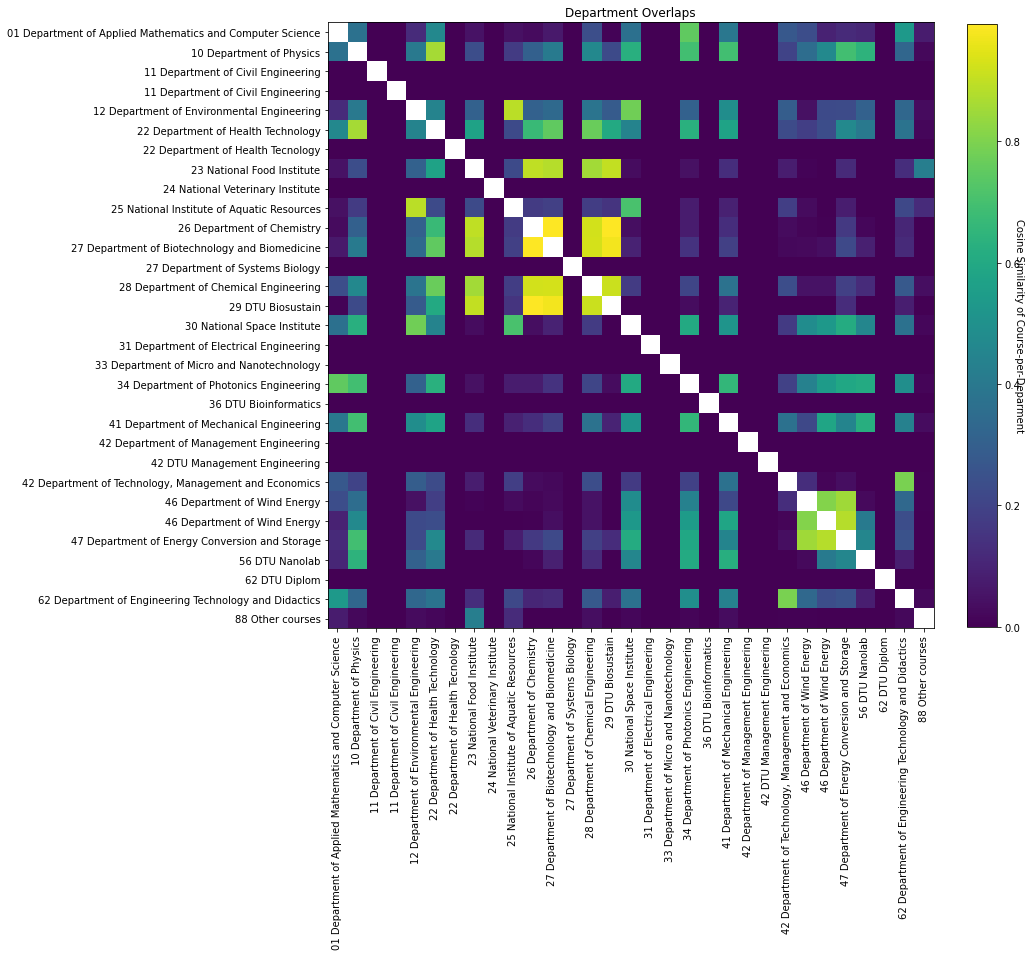

In [28]:
# Index it by department
df = df.set_index("Departments")

# Filter out so that we only have the community columns (not the Angle and Pct ones)
df = df[[f"Community_{c}" for c in range(total_communities)]]

# Now we grab our *rows* instead of columns, to get a per-department vector
rows = []
for i, row in df.iterrows():
    rows.append(np.array(row.tolist()))

# Behind the scenes, a heatmap like this is really just an image array
arr = np.full((len(rows), len(rows)), np.nan)

# We go through each department pairwise
for i in range(len(rows)):
    for j in range(i+1, len(rows)):
        
        # We calculate the norm ahead of time (which is what is divided by at the end), just so that
        # we can catch any division-by-zero errors before they happen
        norm = (np.linalg.norm(rows[i])*np.linalg.norm(rows[j]))
        if norm == 0:
            arr[j,i] = 0
        else:
            
            # If it's not zero, Cosine Similarity!
            arr[j,i] = np.dot(rows[i], rows[j])/norm
            
        # And make it symmetrical
        arr[i,j] = arr[j,i]
    
# Now we just plot it!
plt.figure(figsize=(12,12))

plt.imshow(arr)
plt.xticks(range(len(rows)), df.index, rotation=90)
plt.yticks(range(len(rows)), df.index)
cbar = plt.colorbar(fraction=0.045)
cbar.ax.set_ylabel("Cosine Similarity of Course-per-Community", rotation=270)

plt.title("Department Overlaps")
plt.show()

In the plot above, we see how similar each department is with every other department based on the *community distribution* their courses belong to. We see for example that some of the highest seem to be *Department of Chemistry* together with *Department of Biotechnology and Biomedicine.* That makes total sense, but we also see that the Department of Physics seem to have a notable overlap with Department of Health Technology. National Food Institute seems to share a lot in common with chemistry, biotechnology, and biosustain. The matrix is of course *symmetric* as the same similarity goes both ways.

Additionally, we also see that there are a few inconsistensies across department naming schemes in each course. For example, you may spot that there are **3 different Department 42's,** which are all spelled slightly differently. There's also copies of Department 11, 22, and 27. The one in 22 is simply misspelled. Department 46 also has a duplicate, though the spelling difference is invisible to us here, likely due to it being an inconsistency in some special characters, such as a newline at the end (we found a lot of that!). Maybe DTU should implement some sort of *dropdown* rather than text field, to avoid inconsistencies across different typings.

---

## Teachers across Communities

Finally, let's put our *teachers* dataset to some use too. We already know all courses that belong to what communities, but could it be said that the same teachers generally teach within the same related topics? Or do we see an even distribution across all communities, almost random? _What way could we possibly showcase how prominent each teacher is in each community?_

Well, what better way than **WordCloud'ing _them!_**

In this following plot *(which is also interactive by the way)*, we will display a WordCloud of teacher names for each community, where the *weight* of that name in the WordCloud is proportional to the amount of courses that teacher owns in this community. In order to provide a bit more technical insight into it too, we will also throw in a little bonus bar chart below so that you can see the exact values too (hover!). Additionally, we will also add in the actual community TF-IDF scores, just as a reminder of what community you're looking at.

---

First off, to make it nice and pretty, we will utilize WordCloud's **mask** functionality, where the WordCloud is contained within a certain area. We will mask the teachers' names in a circle in the middle, and then use another mask to display the words *around* the ball of teachers! This allows us to showcase it all in one, beautiful plot, rather than those old boring square boxes of words.

So below, we will specify those masks:

In [29]:
# This is the width and height of the full wordcloud image
width = 950
height = 500
Y,X = np.ogrid[:height, :width]

# We compute the distance from the center at every pixel
dist = np.sqrt((X-width/2)**2 + (Y-height/2)**2)

# The inner circle mask is all pixels within a radius of 250
mask = (~(dist <= 250))*255

# The outer ring mask is every pixel between 250 and 475 in radius
mask2 = (~((dist >= 250) & (dist <= 475)))*255

Now we can start to count how many courses each teacher has, in each community. This is simply done by iterating over the courses in each community, looking up the responsible and co-responsible, and adding +1 to their count in a dictionary indexed by the teacher name:

In [30]:
# Count up how many courses each teacher has in each community!
community_teachers = []
for c, courselist in enumerate(community_courses):
    
    # This is the dictionary mapping Teacher into Course Count
    teachers_c = {}
    
    # Now we go through the courses in this community
    for c2 in courselist:
        
        # We look it up, and add the Responsible's name to the dictionary and +1
        course = courses[c2]
        teachers_c[course["Responsible"]] = teachers_c.setdefault(course["Responsible"], 0) + 1
        
        # Then we do the same for all co-responsible
        if "CoResponsible" in course:
            for teacher in course["CoResponsible"]:
                teachers_c[teacher] = teachers_c.setdefault(teacher, 0) + 1
    
    # And add our dictionary to the list. It's WordCloud-ready!
    community_teachers.append(teachers_c)

Just like before, we need to generate the WordClouds as png images in order for Bokeh to allow us to add them, however this work has also already been done for you, and is instead loaded off of the Github. In case you're wondering how exactly we did it though, the code can still be inspected below:

In [31]:
if False:
    
    # Go through our previously generated teacher lists
    for c, teachers_c in enumerate(community_teachers):
        
        # Additionally, also get the TF-IDF scores for this community (for the outer ring)
        c_row = community_tfidf.getrow(c)
        term_scores = {vocabulary_reverse[word]: score for word, score in zip(c_row.indices, c_row.data)}
        
        # Now we make the teacher WordCloud, with specifying "mask=mask"
        # We fit it to the teachers dictionary, so that the weight is the course count
        wc = wordcloud.WordCloud(background_color=None, mode="RGBA", colormap="autumn", width=width, height=height, mask=mask, prefer_horizontal=1.0)
        wc.fit_words(teachers_c)
        
        # Then we do the TF-IDF scores for the community as well, but in the outer mask "mask=mask2"
        wc2 = wordcloud.WordCloud(background_color=None, mode="RGBA", colormap="winter", width=width, height=height, mask=mask2, prefer_horizontal=1.0, max_font_size=36)
        wc2.fit_words(term_scores)

        # And we save the files
        wc.to_file(f"Teachers{c}.png")
        wc2.to_file(f"Keywords{c}.png")
        
    # In case you ran this locally anyway, we will then refer to the local file
    imgurl_teachers = "Teachers{0}.png"
    imgurl_keywords = "Keywords{0}.png"
else:
    
    # Otherwise, we will just grab them off Github
    imgurl_teachers = "https://raw.githubusercontent.com/s164428/SocialNetworksMarvelDCData/main/wordcloud/Teachers{0}.png"
    imgurl_keywords = "https://raw.githubusercontent.com/s164428/SocialNetworksMarvelDCData/main/wordcloud/Keywords{0}.png"

Now we have our WordCloud images ready to be used together to make the one full plot!

The idea is this: Create a big floating WordCloud circle of all the teacher names in each community, and surround them with the TF-IDF scores of all the descriptive terms of the courses of that community, in a different color so that it can be seen as separate. Then, put all this over a *bar chart* that displays the actual course count for each community per teacher, which can give a direct view into the meaning behind the sizes of the names. Finally, tab this all up in one tab for each community, so they can all be switched between interactively!

In [32]:
# This isn't actually used in the final plots ... but if you wanted to, you could set this as the colors for the bar char
cm = plt.cm.get_cmap("hsv")

# Start creating our tabs
plist = []
for c, courselist in enumerate(community_courses):
    
    # Place both WordClouds in the same figure, so that they merge together
    # Since they have transparent backgrounds, this works :)
    p = figure(width=950, height=500)
    p.image_url(url=[imgurl_teachers.format(c)], x=0, y=0, w=1, h=1)
    p.image_url(url=[imgurl_keywords.format(c)], x=0, y=0, w=1, h=1)
    
    # (No axis or labels for those)
    p.axis.axis_label = None
    p.axis.visible = False
    p.grid.grid_line_color = None
    p.outline_line_color = None
    p.title = "Teachers in Community"
    
    # Now prepare the data for the bar chart
    df = pd.DataFrame([community_teachers[c].keys(), community_teachers[c].values()]).T.rename(columns={0: "Teacher", 1: "Count"})
    df["Color"] = [to_hex(cm(i)) for i in np.linspace(0,1, len(df.Teacher))]
    df["Pct"] = (df.Count/sum(df.Count))*100
    cds = ColumnDataSource(df)
    
    # ... and then create the bar chart!
    p2 = figure(width=950, height=300, y_range=(0, max(df.Count)))
    p2.vbar(x="index", top="Count", width=0.85, color="orange", line_color="black", source=cds)
    
    # We wanna give it a hover tool too, so you can inspect the bars and who they represent!
    p2.add_tools(HoverTool(tooltips=[("Teacher", "@Teacher"), ("Courses", "@Count (@Pct{0.2f}%)")], mode="vline"))
    
    # We will disable the ticks on the x-axis, as well as the text, to just provide a simple floor to the plot
    p2.xaxis.major_tick_line_color = None
    p2.xaxis.minor_tick_line_color = None
    p2.xaxis.major_label_text_color = None
    
    # And then we simply create the tab out of this
    plist.append(Panel(child=layout(column(p, p2)), title=f"Community {c+1}"))
    
# And then we plot all tabs!
p = Tabs(tabs=plist)
show(p)

And there we go! Play around with it! See if you can discover anything interesting about the structure of these communities! *Do you maybe see your own name?*

Overall, we see that in quite a lot of communities, most teachers often only have 1 course, whereas a few seem to dominate the rest. This is most noticeable in *Community 7* where Isa Keller-Andreasen has *over 50 courses!* The terms around the teachers tells us this is a management and coaching type of community, which may imply Isa could be a coach or maybe even supervisor for a lot of individual *projects*. And as it turns out, she is indeed [the head of study](https://orbit.dtu.dk/en/persons/isa-keller-andreasen).

Community 1, which seems to center alot around math, is dominated by Carsten Knudsen, while Community 4 has the highest course count of *Per* Knudsen. This course belongs to Community 11m where we see Christian D. Jensen having the most at 16 courses. We do also see Sune Lehmann Jørgensen with two, super nice, very enjoyable courses in here.

---

And that concludes our investigation of the DTU Course Base similarity network! We have discovered how the courses form communities around their topics, and how the departments overlap across these communities. We have also seen how the teachers distribute across these various topics, and which neighbors this *wonderful* course has. How very interesting.